# Binary neural network

On veux tester la binarisation des poids du réseau neuronal durant l'apprentissage.
On le test sur CIFAR-10.

## Import Modules

In [1]:
# Use GPU for Theano, comment to use CPU instead of GPU
# Tensorflow uses GPU by default
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
# To visiualize models
from keras.utils import plot_model

# If using tensorflow, set image dimensions order
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

## Binary nn

In [4]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
# Evolution of learning rate

from binary_ops import binary_tanh as binary_tanh_op
from binary_layers import BinaryDense, BinaryConv2D, Clip

class DropoutNoScale(Dropout):
    '''Keras Dropout does scale the input in training phase, which is undesirable here.
    '''
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed) * (1 - self.rate)
            return K.in_train_phase(dropped_inputs, inputs,
                                    training=training)
        return inputs

def binary_tanh(x):
    return binary_tanh_op(x)

## Pre-processings : 

- Global contrast normalization
- ZCA whitening

In [5]:
import numpy as np
import scipy
import scipy.misc
from PIL import Image
from __future__ import division

def normalization(X, up):
    """ Normalize X beetween its minimum and up """
    return (X - np.min(X)) * up / (np.max(X) - np.min(X))

def global_contrast_normalization(Y):
    """ Return image after GCN """
    X = Y.copy()
    average = np.mean(X)
    dev_stand = np.std(X)
    
    for i in range(0, len(X)):
        av = X[i] - average
        dev = av / dev_stand
        #X[i] = normalization(dev, 254.0)
        X[i] = (dev - np.min(dev)) * 254.0 / (np.max(dev) - np.min(dev))
    return X
    
def zca_whiten(x_train, y_train):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X_train and y_train
    OUTPUT: Whiten X_train
    """
    # Attention, fonction sale
    datagen = ImageDataGenerator(zca_whitening=True)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    flow = datagen.flow(x_train, y_train, batch_size=1, shuffle=False)

    whiten_images = []

    for _ in range(x_train.shape[0]):
        x, y = flow.next()
        img = normalization(x[0], 1.0)
        whiten_images.append(img)
        
    return np.array(whiten_images)

## Function to load outside CIFAR-10 images

In [6]:
import cv2

#Choisit le test set
#Source = blurred, normal, etc..
classes = ['airplanes', 'automobiles', 'birds', 'cats', 'deers', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

def pick_test_set(source="cifar10"):
    # Resized, Rotated, Blurred, ColorsInverted, ContrastDecrease, HighContrast, LowContrast, Noisy, NoisyBlur, NoisyRotated, Others
    images = []
    labels = []
    for dossier, sous_dossiers, fichiers in os.walk("Images/" + source):
        split = dossier.split("/")
        classe = ""
        if (len(split) >=3):
            classe = split[2]
            #print("Processing " + classe + "...")
        
        #Pour l'instant on ne garde que les vraies classes
        if (classe != "birdogs" and classe != "birdsdogs" and classe != "catsdogs" and classe != "others"):
            print("Processing " + classe + "...")
            
            for fichier in fichiers: #Pour chaque image

                path = dossier + "/"+ fichier
                img = cv2.imread(path)
                img = img[:,:,::-1] # BGR to RGB
                # print(img.shape)
                # TODO
                image = np.transpose(np.reshape(img,(32,32,3)), (2,0,1)) # To CIFAR format
                
                labels.append([classes.index(classe)])
                images.append(image)
                
    return np.array(images), np.array(labels)

## Load CIFAR10 Dataset and Test data

In [7]:
# Choosing test data between : cifar10, Resized, Rotated, Blurred, ColorsInverted, ContrastDecrease, 
#                              HighContrast, LowContrast, Noisy, NoisyBlur, NoisyRotated, Others
source = "cifar10"
##################

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

if source != "cifar10":
    # USE OUR TEST DATA
    test_features, test_labels = pick_test_set(source)

num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## Save or load pre-processed images

In [8]:
import pickle

def dump_data(data, data_file):
    # Save
    print("Saving data to {}".format(data_file))
    output = open(data_file, 'wb')
    pickle.dump(data, output)
    output.close()

def load_data(data_file):
    # Load
    print("Load data from {}".format(data_file))
    pkl_file = open(data_file, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## Data pre-processing

In [9]:
def preprocessing(features, labels, gcn=False, zca=False):
    # Preprocessing on features
    
    if gcn:
        # Global Contrast Normalization
        print("Global Contrast Normalization...")
        for i in range(len(features)):
            features[i] = global_contrast_normalization(features[i])

    # Pre-processing
    features = features.astype('float32')/255
    
    if zca:
        # ZCA whitening
        print("ZCA Whitening...")
        features = zca_whiten(features, labels) 
    
    return features

In [11]:
# Dossier Images/PKL

load = False
save = False

path = "Images/PKL/"
if not os.path.exists(path):
    os.makedirs(path)
    
train_file = "train.pkl"
test_file = source + ".pkl"

# If train features already preprocessed 
if os.path.exists(path + train_file) and load: # 50000 CIFAR-10 images
    print("Loading train : {}".format(train_file))
    train_features = load_data(path + train_file)

else:
    print("Processing train features")
    train_features = preprocessing(train_features, train_labels, gcn=True)
    if save:
        dump_data(train_features, path + train_file)

# If test features already preprocessed
if os.path.exists(path + test_file) and load:
    print("Loading test : {}".format(test_file))
    test_features = load_data(path + test_file)
    
else:
    print("Processing test : {}".format(source))
    test_features = preprocessing(test_features, test_labels, gcn=True)
    if save:
        dump_data(test_features, path + test_file)

Processing train features
Global Contrast Normalization...
Processing test : cifar10
Global Contrast Normalization...


In [12]:
train_features.shape

(50000, 3, 32, 32)

In [13]:
'''
i = 21

img = tra[i]
img = normalization(img, 1.0)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.show()
#print(img)

im = train_features[i]
im = np.transpose(im, (1, 2, 0))
plt.imshow(im)
plt.show()
#print(im)
'''

'\ni = 21\n\nimg = tra[i]\nimg = normalization(img, 1.0)\nimg = np.transpose(img, (1, 2, 0))\nplt.imshow(img)\nplt.show()\n#print(img)\n\nim = train_features[i]\nim = np.transpose(im, (1, 2, 0))\nplt.imshow(im)\nplt.show()\n#print(im)\n'

## Show Examples from Each Class

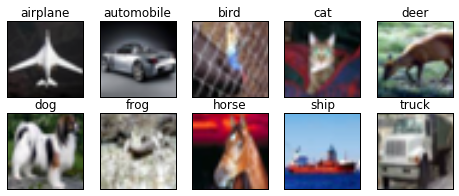

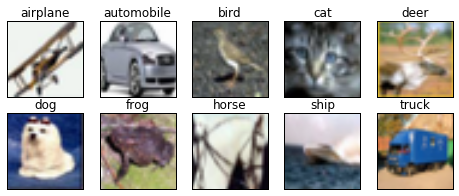

In [14]:
# y'a un truc qui deconne, soit ici, soit dans la GCN...

def show_examples(features, labels):

    class_names = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
    fig = plt.figure(figsize=(8,3))
    for i in range(num_classes):
        ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
        idx = np.where(labels[:]==i)[0]
        features_idx = features[idx,::]
        img_num = np.random.randint(features_idx.shape[0])
        im = np.transpose(features_idx[img_num,::], (1, 2, 0))
        ax.set_title(class_names[i])
        plt.imshow(im)
    plt.show()
    
show_examples(train_features, train_labels)
show_examples(test_features, test_labels)

## Convert class labels to binary class labels

In [15]:
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Function to plot model accuracy and loss 

In [16]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Funtion to compute test accuracy

In [17]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Function to train the network

In [18]:
def train(model, callbacks=None, nb_epoch=10, batch_size=128, verbose=1, lr_start=1e-3, lr_end=1e-4, save=False, h5_file="model.h5"):
    # Train the model
    
    lr_decay = (lr_end / lr_start)**(1. / nb_epoch)
    
    if callbacks==None:
        lr_scheduler = LearningRateScheduler(lambda e: lr_start * lr_decay ** e)
        callbacks = [lr_scheduler]
    
    start = time.time()
    if save: # Boolean save means we save the model at each epoch
        for _ in range(nb_epoch):
            model_info = model.fit(train_features, train_labels, 
                               batch_size=batch_size, nb_epoch=1, 
                               validation_data = (test_features, test_labels), 
                               verbose=verbose, callbacks=callbacks)
            save_weights(model, h5_file)
        
    else:
        model_info = model.fit(train_features, train_labels, 
                               batch_size=batch_size, nb_epoch=nb_epoch, 
                               validation_data = (test_features, test_labels), 
                               verbose=verbose, callbacks=callbacks)
    end = time.time()
    # plot model history
    plot_model_history(model_info)
    print(type(model_info))
    print "Model took %0.2f seconds to train"%(end - start)
    # compute test accuracy
    print "Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model)

## Save and load trained model

In [19]:
def save_weights(model, h5_file):
    # serialize weights to HDF5
    model.save_weights(h5_file)
    print("Saved model to disk")
    
def load_weights(model, h5_file):
    # load weights into new model
    model.load_weights(h5_file)
    print("Loaded model from disk")
    #return model

## Simple network, without binarization

In [ ]:
num_unit = 100
num_hidden = 3
lr_start = 1e-3

# BN
epsilon = 1e-6
momentum = 0.9

# Define the model
model = Sequential()

# Simple layer
model.add(Flatten(input_shape=(3, 32, 32)))
for i in range(num_hidden):
    model.add(Dense(num_unit, activation='tanh'))
    model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn{}'.format(i)))

# Output layer
model.add(Dense(num_classes, activation='softmax')) # 10SVM (L2-SVM) coming soon

# Display
# model.summary()

# Compile the model
model.compile(loss='squared_hinge', optimizer=Adam(lr=lr_start), metrics=['acc'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
train(model, nb_epoch=200)#, save=True, h5_file="simple_model.h5", nb_epoch=100)

#load_weights(model, "simple_model.h5")
#train(model, nb_epoch=1)

## Paper's architecture, without binarization

In [ ]:
h5_file = "paper_nb.h5"
from keras.regularizers import l2

# BN
epsilon = 1e-6
momentum = 0.9

# Pooling
pool_size = (2, 2)

# Define the model
model = Sequential()

# (2 * 128C3)
model.add(Convolution2D(128, 3, 3, border_mode='same', input_shape=(3, 32, 32), activation='relu'))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn1'.format(i)))

# MP2
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25)) # test

# (2 * 256C3)
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn2'.format(i)))

# MP2
model.add(MaxPooling2D(pool_size=pool_size))

# (2 * 512C3)
model.add(Convolution2D(512, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn3'.format(i)))

# MP2
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten()) # Flat before FC

# (2 * 1024FC)
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn4'.format(i)))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn5'.format(i)))

# Output layer
model.add(Dense(num_classes, activation='linear', W_regularizer=l2(0.01))) # 10SVM (L2-SVM) 

# Display
# model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
train(model, nb_epoch=10)

# Load the model
# model = load(model, h5_file)

# Save the model
save(model, h5_file)

## Simple network, with binarization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
drop0 (DropoutNoScale)       (None, 3, 32, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense1 (BinaryDense)         (None, 100)               307200    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 100)               400       
_________________________________________________________________
act1 (Activation)            (None, 100)               0         
_________________________________________________________________
drop1 (DropoutNoScale)       (None, 100)               0         
_________________________________________________________________
dense2 (BinaryDense)         (None, 100)               10000     
__________

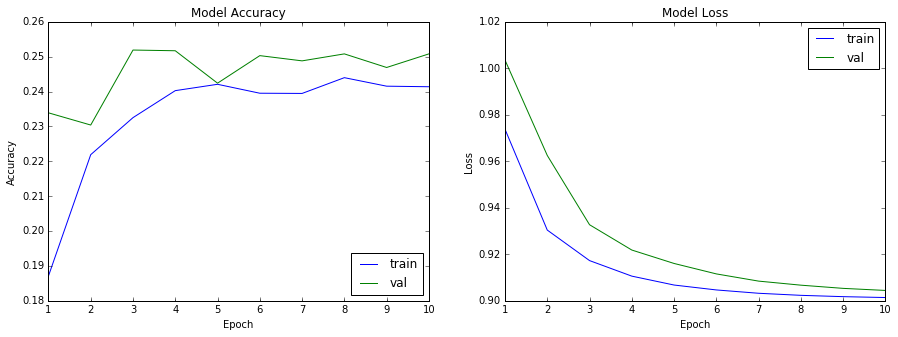

<class 'keras.callbacks.History'>
Model took 108.07 seconds to train
Accuracy on test data is: 25.08
Saved model to disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
drop0 (DropoutNoScale)       (None, 3, 32, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense1 (BinaryDense)         (None, 100)               307200    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 100)               400       
_________________________________________________________________
act1 (Activation)            (None, 100)               0         
_________________________________________________________________
drop1 (DropoutNoScale)       (None, 100)               0         
_____________________

In [38]:
deterministic = True # deterministic or stochastic binarization

H = 'Glorot'

# network
num_unit = 100
num_hidden = 3
use_bias = False

# BN
epsilon = 1e-6
momentum = 0.9

# dropout
drop_in = 0.2
drop_hidden = 0.5

# lr
lr_start = 1e-3

model = Sequential()
model.add(DropoutNoScale(drop_in, input_shape=(3, 32, 32), name='drop0'))
model.add(Flatten())
for i in range(num_hidden):
    model.add(BinaryDense(num_unit, H=H, use_bias=use_bias, # deterministic=deterministic
              name='dense{}'.format(i+1)))
    model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn{}'.format(i+1)))
    model.add(Activation(binary_tanh, name='act{}'.format(i+1)))
    model.add(DropoutNoScale(drop_hidden, name='drop{}'.format(i+1)))
# Output layer
model.add(BinaryDense(10, H=H, use_bias=use_bias, # deterministic=deterministic
          name='dense'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn'))

# Display
# model.summary()
    
model.compile(loss='squared_hinge', optimizer=Adam(lr=lr_start), metrics=['acc'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
train(model, lr_start=lr_start)

save_weights(model, "simple_binary.h5")
#model = load_weights(model, "test.h5")

## Binary weights complex

In [21]:
h5_file = "binary.h5"

# Currently disabled
deterministic = True # deterministic or stochastic binarization

H = 'Glorot'
kernel_lr_multiplier = 'Glorot'

# network
num_unit = 100
num_hidden = 3
use_bias = False

# Conv kernel and Pooling size
kernel_size = (3, 3)
pool_size = (2, 2)

# BN
epsilon = 1e-6
momentum = 0.9

# dropout
drop_in = 0.2
drop_hidden = 0.5

# lr
lr_start = 1e-3

# Define the model
model = Sequential()

# (2 * 128C3)
model.add(BinaryConv2D(128, deterministic=deterministic, kernel_size=kernel_size, input_shape=(3, 32, 32),
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv1'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn1'))
model.add(Activation(binary_tanh, name='act1'))

model.add(BinaryConv2D(128, deterministic=deterministic, kernel_size=kernel_size,
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv2'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn2'))
model.add(Activation(binary_tanh, name='act2'))

# MP2
model.add(MaxPooling2D(pool_size=pool_size, name='pool1', data_format='channels_first'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn3'))
model.add(Activation(binary_tanh, name='act3'))

# (2 * 256C3)
model.add(BinaryConv2D(256, deterministic=deterministic, kernel_size=kernel_size, input_shape=(3, 32, 32),
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv3'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn4'))
model.add(Activation(binary_tanh, name='act4'))

model.add(BinaryConv2D(256, deterministic=deterministic, kernel_size=kernel_size,
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv4'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn5'))
model.add(Activation(binary_tanh, name='act5'))

# MP2
model.add(MaxPooling2D(pool_size=pool_size, name='pool2', data_format='channels_first'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn6'))
model.add(Activation(binary_tanh, name='act6'))

# (2 * 512C3)
model.add(BinaryConv2D(512, deterministic=deterministic, kernel_size=kernel_size, input_shape=(3, 32, 32),
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv5'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn7'))
model.add(Activation(binary_tanh, name='act7'))

model.add(BinaryConv2D(512, deterministic=deterministic, kernel_size=kernel_size,
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv6'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn8'))
model.add(Activation(binary_tanh, name='act8'))

# MP2
model.add(MaxPooling2D(pool_size=pool_size, name='pool3', data_format='channels_first'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn9'))
model.add(Activation(binary_tanh, name='act9'))

# Flat before FC
model.add(Flatten()) 

# (2 * 1024FC)

model.add(BinaryDense(1024, H=H, use_bias=use_bias,
          name='dense1'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn10'))
model.add(Activation(binary_tanh, name='act10'))
model.add(DropoutNoScale(drop_hidden, name='drop1'))

model.add(BinaryDense(1024, H=H, use_bias=use_bias,
          name='dense2'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn11'))
model.add(Activation(binary_tanh, name='act11'))
model.add(DropoutNoScale(drop_hidden, name='drop2'))

# Output layer
model.add(BinaryDense(10, H=H, use_bias=use_bias,
          name='dense'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn'))
#model.add(Dense(num_classes, activation='linear', W_regularizer=l2(0.01))) # 10SVM (L2-SVM) 

# Compile the model
model.compile(loss='squared_hinge', optimizer=Adam(lr=lr_start), metrics=['acc'])

# Display
model.summary()

# Train the model
train(model, lr_start=lr_start, save=True, h5_file=h5_file, batch_size=50)

# Load the model
# model = load(model, h5_file)

# Save the model
#save(model, yaml_file, h5_file)

NameError: name 'i' is not defined